In [197]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.signal import butter, lfilter, freqz, filtfilt
import pandas as pd
import xlsxwriter 
import os
import glob as glob 
import statistics

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [110]:
#Full reads first 7 mins of data as min time is 8 mins


#Creating Directories

if not os.path.isdir('EMG_Spectrogram'):
    os.mkdir('EMG_Spectrogram')
if not os.path.isdir('EMG_Spectrogram/PSD_Data_Full'):
    os.mkdir('EMG_Spectrogram/PSD_Data_Full')
if not os.path.isdir('EMG_Spectrogram/Plots_Full'):
    os.mkdir('EMG_Spectrogram/Plots_Full')
if not os.path.isdir('EMG_Spectrogram/PSD_Data_First'):
    os.mkdir('EMG_Spectrogram/PSD_Data_First')
if not os.path.isdir('EMG_Spectrogram/Plots_First'):
    os.mkdir('EMG_Spectrogram/Plots_First')
    
    
#Sheet Names for reading from files
sheets=['Rel_Dri','Str_Dri','Cal','Math']

#List of files to be read
dir_list = glob.glob('EMG_Filtered_Split/*.xlsx')
dir_list.sort()

#File for writing final output
workbook_full = xlsxwriter.Workbook('EMG_Spectrogram/PSD_Data_Full/EMG_PSD_data_Full.xlsx') 
workbook_first = xlsxwriter.Workbook('EMG_Spectrogram/PSD_Data_First/EMG_PSD_data_First.xlsx') 
bold = workbook_full.add_format({'bold': True})
bold = workbook_first.add_format({'bold': True})
row=0

#Name and col ref to channels
channel=['C1','C2']
col={'C1':2,'C2':3}


for i in range(len(dir_list)):
    #creating save path for fig and file for full data
    savefigpath_full=dir_list[i].replace('EMG_Filtered_Split','EMG_Spectrogram/Plots_Full')
    filepath_full=dir_list[i].replace('EMG_Filtered_Split','EMG_Spectrogram/PSD_Data_Full')
    filepath_full=filepath_full.replace('.xlsx','_Full_PSD.xlsx')
    savefigpath_full=savefigpath_full.replace('.xlsx','_Full_')
    
    #paths for first min files
    savefigpath_first=dir_list[i].replace('EMG_Filtered_Split','EMG_Spectrogram/Plots_First')
    filepath_first=dir_list[i].replace('EMG_Filtered_Split','EMG_Spectrogram/PSD_Data_First')
    filepath_first=filepath_first.replace('.xlsx','_First_PSD.xlsx')
    savefigpath_first=savefigpath_first.replace('.xlsx','_First_')
    
    #participant name information
    partname=dir_list[i].replace('EMG_Filtered_Split','')
    partname=partname.replace('.xlsx','')
    
    #Excel writer for full and first min files
    writer_full = pd.ExcelWriter(filepath_full)
    writer_first = pd.ExcelWriter(filepath_first)
    
    RD = pd.read_excel(dir_list[i], sheets[0],header=0)
    SD = pd.read_excel(dir_list[i], sheets[1],header=0)
    C = pd.read_excel(dir_list[i], sheets[2],header=0)
    M = pd.read_excel(dir_list[i], sheets[3],header=0)

    
        
    #For loop for looping through the 2 channels
    for j in range(len(channel)):        
        
        fig=plt.figure()
        #Doing PSD on the Full data and plotting it
        RD_Data=plt.psd(RD[RD.columns[col[channel[j]]]][:7*60*512], Fs=512,color='b',label='Relaxed_Driving')
        SD_Data=plt.psd(SD[SD.columns[col[channel[j]]]][:7*60*512], Fs=512,color='r',label='Stressed_Driving')
        plt.xlim((10,100))
        plt.legend()
        plt.savefig(savefigpath_full+channel[j]+'_Driv.png')
        plt.clf()
        plt.figure()
        C_Data=plt.psd(C[C.columns[col[channel[j]]]][:7*60*512], Fs=512,color='b',label='Calm')
        M_Data=plt.psd(M[M.columns[col[channel[j]]]][:7*60*512], Fs=512,color='r',label='Math')
        plt.legend()
        plt.savefig(savefigpath_full+channel[j]+'_Cond.png')
        plt.clf()

        if workbook_full.get_worksheet_by_name(channel[j]):
            worksheet_full=workbook_full.get_worksheet_by_name(channel[j])
        else:
            worksheet_full = workbook_full.add_worksheet(channel[j])
            row=0
            worksheet_full.write(row,0,'Participant',bold)
            worksheet_full.write(row,1,'MPF_Stressed_Driving',bold)
            worksheet_full.write(row,2,'MPF_Relaxed_Driving',bold)
            worksheet_full.write(row,3,'(MPF_Rel-MPF_Str)',bold)
            worksheet_full.write(row,4,'Area_Str',bold)
            worksheet_full.write(row,5,'Area_Rel',bold)
            worksheet_full.write(row,6,'Max_Power_Str',bold)
            worksheet_full.write(row,7,'Dom_Freq_Str',bold)
            worksheet_full.write(row,8,'Max_Power_Rel',bold)
            worksheet_full.write(row,9,'Dom_Freq_Rel',bold)

            worksheet_full.write(row,11,'Participant',bold)
            worksheet_full.write(row,12,'MPF_Math_Driving',bold)
            worksheet_full.write(row,13,'MPF_Calm_Driving',bold)
            worksheet_full.write(row,14,'(MPF_Calm-Math_Str)',bold)
            worksheet_full.write(row,15,'Area_Math',bold)
            worksheet_full.write(row,16,'Area_Calm',bold)
            worksheet_full.write(row,17,'Max_Power_Math',bold)
            worksheet_full.write(row,18,'Dom_Freq_Math',bold)
            worksheet_full.write(row,19,'Max_Power_Calm',bold)
            worksheet_full.write(row,20,'Dom_Freq_Calm',bold)
            
            powerdata_full_RD=np.empty((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(dir_list),len(channel)))
            powerdata_full_SD=np.empty((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(dir_list),len(channel)))
            powerdata_full_C=np.empty((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(dir_list),len(channel)))
            powerdata_full_M=np.empty((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(dir_list),len(channel)))
        
        
        #Doing PSD on the first min data and plotting it
        RD_Data_First=plt.psd(RD[RD.columns[col[channel[j]]]][:60*512], Fs=512,color='b',label='Relaxed_Driving')
        SD_Data_First=plt.psd(SD[SD.columns[col[channel[j]]]][:60*512], Fs=512,color='r',label='Stressed_Driving')
        plt.xlim((10,100))
        plt.legend()
        plt.savefig(savefigpath_first+channel[j]+'_Driv.png')
        plt.clf()
        plt.figure()
        C_Data_First=plt.psd(C[C.columns[col[channel[j]]]][:60*512], Fs=512,color='b',label='Calm')
        M_Data_First=plt.psd(M[M.columns[col[channel[j]]]][:60*512], Fs=512,color='r',label='Math')
        plt.legend()
        plt.savefig(savefigpath_first+channel[j]+'_Cond.png')
        plt.clf()
        
        
        
        if workbook_first.get_worksheet_by_name(channel[j]):
                worksheet_first=workbook_first.get_worksheet_by_name(channel[j])
        else:
            worksheet_first = workbook_first.add_worksheet(channel[j])
            row=0
            worksheet_first.write(row,0,'Participant',bold)
            worksheet_first.write(row,1,'MPF_Stressed_Driving',bold)
            worksheet_first.write(row,2,'MPF_Relaxed_Driving',bold)
            worksheet_first.write(row,3,'(MPF_Rel-MPF_Str)',bold)
            worksheet_first.write(row,4,'Area_Str',bold)
            worksheet_first.write(row,5,'Area_Rel',bold)
            worksheet_first.write(row,6,'Max_Power_Str',bold)
            worksheet_first.write(row,7,'Dom_Freq_Str',bold)
            worksheet_first.write(row,8,'Max_Power_Rel',bold)
            worksheet_first.write(row,9,'Dom_Freq_Rel',bold)

            worksheet_first.write(row,11,'Participant',bold)
            worksheet_first.write(row,12,'MPF_Math_Driving',bold)
            worksheet_first.write(row,13,'MPF_Calm_Driving',bold)
            worksheet_first.write(row,14,'(MPF_Calm-Math_Str)',bold)
            worksheet_first.write(row,15,'Area_Math',bold)
            worksheet_first.write(row,16,'Area_Calm',bold)
            worksheet_first.write(row,17,'Max_Power_Math',bold)
            worksheet_first.write(row,18,'Dom_Freq_Math',bold)
            worksheet_first.write(row,19,'Max_Power_Calm',bold)
            worksheet_first.write(row,20,'Dom_Freq_Calm',bold)
            
            powerdata_first_RD=np.empty((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(dir_list),len(channel)))
            powerdata_first_SD=np.empty((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(dir_list),len(channel)))
            powerdata_first_C=np.empty((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(dir_list),len(channel)))
            powerdata_first_M=np.empty((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(dir_list),len(channel)))
            row+=1
            
        
        

        
        
        
        #Convert values to decibels for Power
        """
        For First minute Data
        Conversion to log and calculating parameters 
        Saving to excel file
        """
        RD_Data=list(RD_Data)
        SD_Data=list(SD_Data)
        C_Data=list(C_Data)
        M_Data=list(M_Data)
        RD_Data[0]=10*np.log10(RD_Data[0])
        SD_Data[0]=10*np.log10(SD_Data[0])
        C_Data[0]=10*np.log10(C_Data[0])
        M_Data[0]=10*np.log10(M_Data[0])
        
        MPF_RD=np.linalg.norm(np.multiply(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)],RD_Data[1][(RD_Data[1]>10)&(RD_Data[1]<100)]),1)/np.linalg.norm(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)],1)
        MPF_SD=np.linalg.norm(np.multiply(SD_Data[0][(SD_Data[1]>10)&(SD_Data[1]<100)],SD_Data[1][(SD_Data[1]>10)&(SD_Data[1]<100)]),1)/np.linalg.norm(SD_Data[0][(SD_Data[1]>10)&(SD_Data[1]<100)],1)
        MPF_C=np.linalg.norm(np.multiply(C_Data[0][(C_Data[1]>10)&(C_Data[1]<100)],C_Data[1][(C_Data[1]>10)&(C_Data[1]<100)]),1)/np.linalg.norm(C_Data[0][(C_Data[1]>10)&(C_Data[1]<100)],1)
        MPF_M=np.linalg.norm(np.multiply(M_Data[0][(M_Data[1]>10)&(M_Data[1]<100)],M_Data[1][(M_Data[1]>10)&(M_Data[1]<100)]),1)/np.linalg.norm(M_Data[0][(M_Data[1]>10)&(M_Data[1]<100)],1)
        
        Math_PSD_DATA=pd.DataFrame({'freq':M_Data[1][(M_Data[1]>10)&(M_Data[1]<100)],'Power':M_Data[0][(M_Data[1]>10)&(M_Data[1]<100)]})
        Calm_PSD_DATA=pd.DataFrame({'freq':C_Data[1][(C_Data[1]>10)&(C_Data[1]<100)],'Power':C_Data[0][(C_Data[1]>10)&(C_Data[1]<100)]})
        RD_PSD_DATA=pd.DataFrame({'freq':RD_Data[1][(RD_Data[1]>10)&(RD_Data[1]<100)],'Power':RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]})
        SD_PSD_DATA=pd.DataFrame({'freq':SD_Data[1][(SD_Data[1]>10)&(SD_Data[1]<100)],'Power':SD_Data[0][(SD_Data[1]>10)&(SD_Data[1]<100)]})
        SD_PSD_DATA.to_excel(writer_full,'Stressed_Drive_'+channel[j])
        RD_PSD_DATA.to_excel(writer_full,'Relaxed_Drive_'+channel[j])
        Math_PSD_DATA.to_excel(writer_full,'Math_'+channel[j])
        Calm_PSD_DATA.to_excel(writer_full,'Calm_'+channel[j])

        
        
        worksheet_full.write(row,0,partname)
        worksheet_full.write(row,1,MPF_SD)
        worksheet_full.write(row,2,MPF_RD)
        worksheet_full.write(row,3,(MPF_RD-MPF_SD))
        worksheet_full.write(row,4,np.linalg.norm(np.multiply(SD_Data[0][(SD_Data[1]>10)&(SD_Data[1]<100)],SD_Data[1][(SD_Data[1]>10)&(SD_Data[1]<100)]),1))
        worksheet_full.write(row,5,np.linalg.norm(np.multiply(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)],RD_Data[1][(RD_Data[1]>10)&(RD_Data[1]<100)]),1))
        worksheet_full.write(row,6,SD_Data[0][np.argmax(SD_Data[0][(SD_Data[1]>10)&(SD_Data[1]<100)])])
        worksheet_full.write(row,7,SD_Data[1][np.argmax(SD_Data[0][(SD_Data[1]>10)&(SD_Data[1]<100)])])
        worksheet_full.write(row,8,RD_Data[0][np.argmax(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)])])
        worksheet_full.write(row,9,RD_Data[1][np.argmax(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)])])
        
        worksheet_full.write(row,11,partname)
        worksheet_full.write(row,12,MPF_M)
        worksheet_full.write(row,13,MPF_C)
        worksheet_full.write(row,14,(MPF_C-MPF_M))
        worksheet_full.write(row,15,np.linalg.norm(np.multiply(M_Data[0][(M_Data[1]>10)&(M_Data[1]<100)],M_Data[1][(M_Data[1]>10)&(M_Data[1]<100)]),1))
        worksheet_full.write(row,16,np.linalg.norm(np.multiply(C_Data[0][(C_Data[1]>10)&(C_Data[1]<100)],C_Data[1][(C_Data[1]>10)&(C_Data[1]<100)]),1))
        worksheet_full.write(row,17,M_Data[0][np.argmax(M_Data[0][(M_Data[1]>10)&(M_Data[1]<100)])])
        worksheet_full.write(row,18,M_Data[1][np.argmax(M_Data[0][(M_Data[1]>10)&(M_Data[1]<100)])])
        worksheet_full.write(row,19,C_Data[0][np.argmax(C_Data[0][(C_Data[1]>10)&(C_Data[1]<100)])])
        worksheet_full.write(row,20,C_Data[1][np.argmax(C_Data[0][(C_Data[1]>10)&(C_Data[1]<100)])])

        
        
        
        """
        For First minute Data
        Conversion to log and calculating parameters 
        Saving to excel file
        """
        RD_Data_First=list(RD_Data_First)
        SD_Data_First=list(SD_Data_First)
        C_Data_First=list(C_Data_First)
        M_Data_First=list(M_Data_First)
        RD_Data_First[0]=10*np.log10(RD_Data_First[0])
        SD_Data_First[0]=10*np.log10(SD_Data_First[0])
        C_Data_First[0]=10*np.log10(C_Data_First[0])
        M_Data_First[0]=10*np.log10(M_Data_First[0])
        
        MPF_RD=np.linalg.norm(np.multiply(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)],RD_Data_First[1][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),1)/np.linalg.norm(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)],1)
        MPF_SD=np.linalg.norm(np.multiply(SD_Data_First[0][(SD_Data_First[1]>10)&(SD_Data_First[1]<100)],SD_Data_First[1][(SD_Data_First[1]>10)&(SD_Data_First[1]<100)]),1)/np.linalg.norm(SD_Data_First[0][(SD_Data_First[1]>10)&(SD_Data_First[1]<100)],1)
        MPF_C=np.linalg.norm(np.multiply(C_Data_First[0][(C_Data_First[1]>10)&(C_Data_First[1]<100)],C_Data_First[1][(C_Data_First[1]>10)&(C_Data_First[1]<100)]),1)/np.linalg.norm(C_Data_First[0][(C_Data_First[1]>10)&(C_Data_First[1]<100)],1)
        MPF_M=np.linalg.norm(np.multiply(M_Data_First[0][(M_Data_First[1]>10)&(M_Data_First[1]<100)],M_Data_First[1][(M_Data_First[1]>10)&(M_Data_First[1]<100)]),1)/np.linalg.norm(M_Data_First[0][(M_Data_First[1]>10)&(M_Data_First[1]<100)],1)
        
        Math_PSD_Data_First=pd.DataFrame({'freq':M_Data_First[1][(M_Data_First[1]>10)&(M_Data_First[1]<100)],'Power':M_Data_First[0][(M_Data_First[1]>10)&(M_Data_First[1]<100)]})
        Calm_PSD_Data_First=pd.DataFrame({'freq':C_Data_First[1][(C_Data_First[1]>10)&(C_Data_First[1]<100)],'Power':C_Data_First[0][(C_Data_First[1]>10)&(C_Data_First[1]<100)]})
        RD_PSD_Data_First=pd.DataFrame({'freq':RD_Data_First[1][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)],'Power':RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]})
        SD_PSD_Data_First=pd.DataFrame({'freq':SD_Data_First[1][(SD_Data_First[1]>10)&(SD_Data_First[1]<100)],'Power':SD_Data_First[0][(SD_Data_First[1]>10)&(SD_Data_First[1]<100)]})
        SD_PSD_Data_First.to_excel(writer_first,'Stressed_Drive_'+channel[j])
        RD_PSD_Data_First.to_excel(writer_first,'Relaxed_Drive_'+channel[j])
        Math_PSD_Data_First.to_excel(writer_first,'Math_'+channel[j])
        Calm_PSD_Data_First.to_excel(writer_first,'Calm_'+channel[j])


        
        worksheet_first.write(row,0,partname)
        worksheet_first.write(row,1,MPF_SD)
        worksheet_first.write(row,2,MPF_RD)
        worksheet_first.write(row,3,(MPF_RD-MPF_SD))
        worksheet_first.write(row,4,np.linalg.norm(np.multiply(SD_Data_First[0][(SD_Data_First[1]>10)&(SD_Data_First[1]<100)],SD_Data_First[1][(SD_Data_First[1]>10)&(SD_Data_First[1]<100)]),1))
        worksheet_first.write(row,5,np.linalg.norm(np.multiply(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)],RD_Data_First[1][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),1))
        worksheet_first.write(row,6,SD_Data_First[0][np.argmax(SD_Data_First[0][(SD_Data_First[1]>10)&(SD_Data_First[1]<100)])])
        worksheet_first.write(row,7,SD_Data_First[1][np.argmax(SD_Data_First[0][(SD_Data_First[1]>10)&(SD_Data_First[1]<100)])])
        worksheet_first.write(row,8,RD_Data_First[0][np.argmax(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)])])
        worksheet_first.write(row,9,RD_Data_First[1][np.argmax(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)])])
        
        worksheet_first.write(row,11,partname)
        worksheet_first.write(row,12,MPF_M)
        worksheet_first.write(row,13,MPF_C)
        worksheet_first.write(row,14,(MPF_C-MPF_M))
        worksheet_first.write(row,15,np.linalg.norm(np.multiply(M_Data_First[0][(M_Data_First[1]>10)&(M_Data_First[1]<100)],M_Data_First[1][(M_Data_First[1]>10)&(M_Data_First[1]<100)]),1))
        worksheet_first.write(row,16,np.linalg.norm(np.multiply(C_Data_First[0][(C_Data_First[1]>10)&(C_Data_First[1]<100)],C_Data_First[1][(C_Data_First[1]>10)&(C_Data_First[1]<100)]),1))
        worksheet_first.write(row,17,M_Data_First[0][np.argmax(M_Data_First[0][(M_Data_First[1]>10)&(M_Data_First[1]<100)])])
        worksheet_first.write(row,18,M_Data_First[1][np.argmax(M_Data_First[0][(M_Data_First[1]>10)&(M_Data_First[1]<100)])])
        worksheet_first.write(row,19,C_Data_First[0][np.argmax(C_Data_First[0][(C_Data_First[1]>10)&(C_Data_First[1]<100)])])
        worksheet_first.write(row,20,C_Data_First[1][np.argmax(C_Data_First[0][(C_Data_First[1]>10)&(C_Data_First[1]<100)])])

        
        powerdata_full_RD[:,i,j]=RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]
        powerdata_full_SD[:,i,j]=SD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]
        powerdata_full_C[:,i,j]=C_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]
        powerdata_full_M[:,i,j]=M_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]
        powerdata_first_RD[:,i,j]=RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]
        powerdata_first_SD[:,i,j]=SD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]
        powerdata_first_C[:,i,j]=C_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]
        powerdata_first_M[:,i,j]=M_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]
        
    writer_full.save()
    writer_first.save()
    plt.clf()
    row+=1

workbook_full.close() 
workbook_first.close() 







/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyError: 'Power'

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

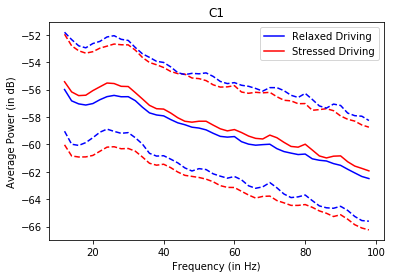

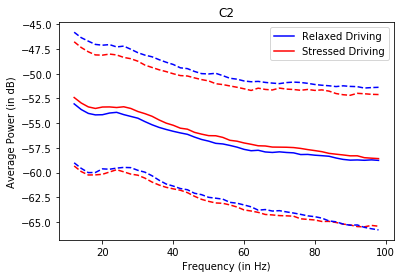

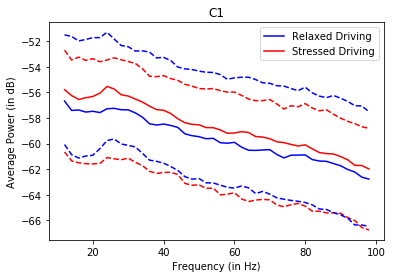

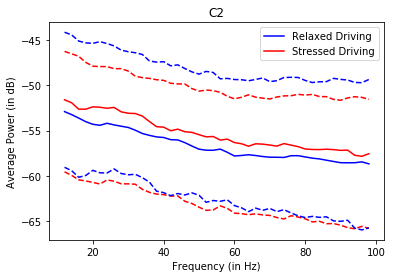

In [188]:
import statistics

"""
Calculate Average and Std for all freqs for full and first min data
"""
Avg_full_RD=np.zeros((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(channel)))
Avg_full_SD=np.zeros((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(channel)))
Avg_full_C=np.zeros((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(channel)))
Avg_full_M=np.zeros((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(channel)))

stdev_full_RD=np.empty((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(channel)))
stdev_full_SD=np.empty((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(channel)))
stdev_full_C=np.empty((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(channel)))
stdev_full_M=np.empty((len(RD_Data[0][(RD_Data[1]>10)&(RD_Data[1]<100)]),len(channel)))

Avg_first_RD=np.zeros((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(channel)))
Avg_first_SD=np.zeros((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(channel)))
Avg_first_C=np.zeros((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(channel)))
Avg_first_M=np.zeros((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(channel)))

stdev_first_RD=np.empty((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(channel)))
stdev_first_SD=np.empty((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(channel)))
stdev_first_C=np.empty((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(channel)))
stdev_first_M=np.empty((len(RD_Data_First[0][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]),len(channel)))

for i in range(len(RD_Data[1][(RD_Data[1]>10)&(RD_Data[1]<100)])):
    for j in range(len(channel)):
        stdev_full_RD[i,j]=statistics.stdev(powerdata_full_RD[i,:,j])
        stdev_full_SD[i,j]=statistics.stdev(powerdata_full_SD[i,:,j])
        stdev_full_C[i,j]=statistics.stdev(powerdata_full_C[i,:,j])
        stdev_full_M[i,j]=statistics.stdev(powerdata_full_M[i,:,j])
        Avg_full_RD[i,j]=statistics.mean(powerdata_full_RD[i,:,j])
        Avg_full_SD[i,j]=statistics.mean(powerdata_full_SD[i,:,j])
        Avg_full_C[i,j]=statistics.mean(powerdata_full_C[i,:,j])
        Avg_full_M[i,j]=statistics.mean(powerdata_full_M[i,:,j])
        
        stdev_first_RD[i,j]=statistics.stdev(powerdata_first_RD[i,:,j])
        stdev_first_SD[i,j]=statistics.stdev(powerdata_first_SD[i,:,j])
        stdev_first_C[i,j]=statistics.stdev(powerdata_first_C[i,:,j])
        stdev_first_M[i,j]=statistics.stdev(powerdata_first_M[i,:,j])
        Avg_first_RD[i,j]=statistics.mean(powerdata_first_RD[i,:,j])
        Avg_first_SD[i,j]=statistics.mean(powerdata_first_SD[i,:,j])
        Avg_first_C[i,j]=statistics.mean(powerdata_first_C[i,:,j])
        Avg_first_M[i,j]=statistics.mean(powerdata_first_M[i,:,j])



"""
Save Average and Std Values
"""
RD_full_Avg=pd.DataFrame(Avg_full_RD)
M_full_Avg=pd.DataFrame(Avg_full_M)
C_full_Avg=pd.DataFrame(Avg_full_C)
SD_full_Avg=pd.DataFrame(Avg_full_SD)
SD_full_Avg.columns=channel
RD_full_Avg.columns=channel
M_full_Avg.columns=channel
C_full_Avg.columns=channel

RD_full_Avg.to_csv(r'EMG_Spectrogram/RD_full_Avg.csv')
SD_full_Avg.to_csv(r'EMG_Spectrogram/SD_full_Avg.csv')
C_full_Avg.to_csv(r'EMG_Spectrogram/C_full_Avg.csv')
M_full_Avg.to_csv(r'EMG_Spectrogram/M_full_Avg.csv')

RD_first_Avg=pd.DataFrame(Avg_first_RD)
M_first_Avg=pd.DataFrame(Avg_first_M)
C_first_Avg=pd.DataFrame(Avg_first_C)
SD_first_Avg=pd.DataFrame(Avg_first_SD)
SD_first_Avg.columns=channel
RD_first_Avg.columns=channel
M_first_Avg.columns=channel
C_first_Avg.columns=channel

RD_first_Avg.to_csv(r'EMG_Spectrogram/RD_first_Avg.csv')
SD_first_Avg.to_csv(r'EMG_Spectrogram/SD_first_Avg.csv')
C_first_Avg.to_csv(r'EMG_Spectrogram/C_first_Avg.csv')
M_first_Avg.to_csv(r'EMG_Spectrogram/M_first_Avg.csv')



RD_full_Stdev=pd.DataFrame(stdev_full_RD)
M_full_Stdev=pd.DataFrame(stdev_full_M)
C_full_Stdev=pd.DataFrame(stdev_full_C)
SD_full_Stdev=pd.DataFrame(stdev_full_SD)
SD_full_Stdev.columns=channel
RD_full_Stdev.columns=channel
M_full_Stdev.columns=channel
C_full_Stdev.columns=channel

RD_full_Stdev.to_csv(r'EMG_Spectrogram/RD_full_Stdev.csv')
SD_full_Stdev.to_csv(r'EMG_Spectrogram/SD_full_Stdev.csv')
C_full_Stdev.to_csv(r'EMG_Spectrogram/C_full_Stdev.csv')
M_full_Stdev.to_csv(r'EMG_Spectrogram/M_full_Stdev.csv')

RD_first_Stdev=pd.DataFrame(stdev_first_RD)
M_first_Stdev=pd.DataFrame(stdev_first_M)
C_first_Stdev=pd.DataFrame(stdev_first_C)
SD_first_Stdev=pd.DataFrame(stdev_first_SD)
SD_first_Stdev.columns=channel
RD_first_Stdev.columns=channel
M_first_Stdev.columns=channel
C_first_Stdev.columns=channel

RD_first_Stdev.to_csv(r'EMG_Spectrogram/RD_first_Stdev.csv')
SD_first_Stdev.to_csv(r'EMG_Spectrogram/SD_first_Stdev.csv')
C_first_Stdev.to_csv(r'EMG_Spectrogram/C_first_Stdev.csv')
M_first_Stdev.to_csv(r'EMG_Spectrogram/M_first_Stdev.csv')

"""
Making plots for average with Std
"""
if not os.path.isdir('EMG_Spectrogram/Mean_Graphs'):
    os.mkdir('EMG_Spectrogram/Mean_Graphs')

freq=RD_Data[1][(RD_Data[1]>10)&(RD_Data[1]<100)]
for j in range(len(channel)):
    plt.figure()
    plt.plot(freq,Avg_full_RD[:,j],'b-',label='Relaxed Driving')
    plt.plot(freq,Avg_full_RD[:,j]+stdev_full_RD[:,j],'r--',label='')
    plt.plot(freq,Avg_full_RD[:,j]-stdev_full_RD[:,j],'r--',label='')
    plt.plot(freq,Avg_full_SD[:,j],'r-',label='Stressed Driving')
    plt.plot(freq,Avg_full_SD[:,j]+stdev_full_SD[:,j],'b--',label='')
    plt.plot(freq,Avg_full_SD[:,j]-stdev_full_SD[:,j],'b--',label='')
    plt.title(channel[j])
    plt.xlabel('Frequency (in Hz)')
    plt.ylabel('Average Power (in dB)')
    plt.legend()
    plt.savefig('EMG_Spectrogram/Mean_Graphs/Mean_Curve'+channel[j]+'.png')
  
freq=RD_Data_First[1][(RD_Data_First[1]>10)&(RD_Data_First[1]<100)]
for j in range(len(channel)):
    plt.figure()
    plt.plot(freq,Avg_first_RD[:,j],'b-',label='Relaxed Driving')
    plt.plot(freq,Avg_first_RD[:,j]+stdev_first_RD[:,j],'r--',label='')
    plt.plot(freq,Avg_first_RD[:,j]-stdev_first_RD[:,j],'r--',label='')
    plt.plot(freq,Avg_first_SD[:,j],'r-',label='Stressed Driving')
    plt.plot(freq,Avg_first_SD[:,j]+stdev_first_SD[:,j],'b--',label='')
    plt.plot(freq,Avg_first_SD[:,j]-stdev_first_SD[:,j],'b--',label='')
    plt.title(channel[j])
    plt.xlabel('Frequency (in Hz)')
    plt.ylabel('Average Power (in dB)')
    plt.legend()
    plt.savefig('EMG_Spectrogram/Mean_Graphs/Mean_Curve_first'+channel[j]+'.png')


In [180]:
"""
Code for rewriting the data for first participant since the array had some junk value
"""
sheets=['Stressed_Drive_C1','Relaxed_Drive_C1','Math_C1','Calm_C1']    
RD = pd.read_excel(r'EMG_Spectrogram/PSD_Data_Full/B303_Full_PSD.xlsx', sheets[1],header=0)
powerdata_full_RD[:,0,0]=RD['Power']
RD = pd.read_excel(r'EMG_Spectrogram/PSD_Data_Full/B303_Full_PSD.xlsx', sheets[0],header=0)
powerdata_full_SD[:,0,0]=RD['Power']
RD = pd.read_excel(r'EMG_Spectrogram/PSD_Data_Full/B303_Full_PSD.xlsx', sheets[3],header=0)
powerdata_full_C[:,0,0]=RD['Power']
RD = pd.read_excel(r'EMG_Spectrogram/PSD_Data_Full/B303_Full_PSD.xlsx', sheets[2],header=0)
powerdata_full_M[:,0,0]=RD['Power']

sheets=['Stressed_Drive_C1','Relaxed_Drive_C1','Math_C1','Calm_C1']    
RD = pd.read_excel(r'EMG_Spectrogram/PSD_Data_First/B303_First_PSD.xlsx', sheets[1],header=0)
powerdata_first_RD[:,0,0]=RD['Power']
RD = pd.read_excel(r'EMG_Spectrogram/PSD_Data_First/B303_First_PSD.xlsx', sheets[0],header=0)
powerdata_first_SD[:,0,0]=RD['Power']
RD = pd.read_excel(r'EMG_Spectrogram/PSD_Data_First/B303_First_PSD.xlsx', sheets[3],header=0)
powerdata_first_C[:,0,0]=RD['Power']
RD = pd.read_excel(r'EMG_Spectrogram/PSD_Data_First/B303_First_PSD.xlsx', sheets[2],header=0)
powerdata_first_M[:,0,0]=RD['Power']

In [198]:
#Full reads first 7 mins of data as min time is 8 mins
#Calculating Area Under the Curve

#Creating Directories

    
    
#Sheet Names for reading from files
sheets=['Rel_Dri','Str_Dri','Cal','Math']

#List of files to be read
dir_list = glob.glob('EMG_Filtered_Split/*.xlsx')
dir_list.sort()

#File for writing final output
workbook_full = xlsxwriter.Workbook('EMG_Spectrogram/PSD_Data_Full/Area_Under_Curve.xlsx') 
bold = workbook_full.add_format({'bold': True})
bold = workbook_first.add_format({'bold': True})
row=0

#Name and col ref to channels
channel=['C1','C2']
col={'C1':2,'C2':3}


for i in range(len(dir_list)):
    
    #participant name information
    partname=dir_list[i].replace('EMG_Filtered_Split','')
    partname=partname.replace('.xlsx','')
    
    #Read the files
    RD = pd.read_excel(dir_list[i], sheets[0],header=0)
    SD = pd.read_excel(dir_list[i], sheets[1],header=0)
    C = pd.read_excel(dir_list[i], sheets[2],header=0)
    M = pd.read_excel(dir_list[i], sheets[3],header=0)

    
        
    #For loop for looping through the 2 channels
    for j in range(len(channel)):        
        if i is len(dir_list)-1
        fig=plt.figure()
        #Doing PSD on the Full data and plotting it
        RD_Data=plt.psd(RD[RD.columns[col[channel[j]]]][:7*60*512], Fs=512,color='b',label='Relaxed_Driving')
        SD_Data=plt.psd(SD[SD.columns[col[channel[j]]]][:7*60*512], Fs=512,color='r',label='Stressed_Driving')
        plt.xlim((10,100))
        plt.legend()
        plt.savefig(savefigpath_full+channel[j]+'_Driv.png')
        plt.clf()
        plt.figure()
        C_Data=plt.psd(C[C.columns[col[channel[j]]]][:7*60*512], Fs=512,color='b',label='Calm')
        M_Data=plt.psd(M[M.columns[col[channel[j]]]][:7*60*512], Fs=512,color='r',label='Math')
        plt.legend()
        plt.savefig(savefigpath_full+channel[j]+'_Cond.png')
        plt.clf()

        if workbook_full.get_worksheet_by_name(channel[j]):
            worksheet_full=workbook_full.get_worksheet_by_name(channel[j])
        else:
            worksheet_full = workbook_full.add_worksheet(channel[j])
            row=0
            worksheet_full.write(row,0,'Participant',bold)
            worksheet_full.write(row,1,'Area_Full_RD',bold)
            worksheet_full.write(row,2,'Area_Full_SD',bold)
            worksheet_full.write(row,3,'Area_Full_C',bold)
            worksheet_full.write(row,4,'Area_Full_M',bold)
            worksheet_full.write(row,6,'Area_First_RD',bold)
            worksheet_full.write(row,7,'Area_First_SD',bold)
            worksheet_full.write(row,8,'Area_First_C',bold)
            worksheet_full.write(row,9,'Area_First_M',bold)
            row+=1

        
        worksheet_full.write(row,0,partname)
        worksheet_full.write(row,1,np.trapz(RD[RD.columns[col[channel[j]]]][:7*60*512], dx = 1/512))
        worksheet_full.write(row,2,np.trapz(SD[SD.columns[col[channel[j]]]][:7*60*512], dx = 1/512))
        worksheet_full.write(row,3,np.trapz(C[C.columns[col[channel[j]]]][:7*60*512], dx = 1/512))
        worksheet_full.write(row,4,np.trapz(M[M.columns[col[channel[j]]]][:7*60*512], dx = 1/512))
        worksheet_full.write(row,6,np.trapz(RD[RD.columns[col[channel[j]]]][:1*60*512], dx = 1/512))
        worksheet_full.write(row,7,np.trapz(SD[SD.columns[col[channel[j]]]][:1*60*512], dx = 1/512))
        worksheet_full.write(row,8,np.trapz(C[C.columns[col[channel[j]]]][:1*60*512], dx = 1/512))
        worksheet_full.write(row,9,np.trapz(M[M.columns[col[channel[j]]]][:1*60*512], dx = 1/512))
        row+=1


workbook_full.close() 








/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [199]:
savefigpath_full


'EMG_Spectrogram/Plots_Full/B326_Full_'